## DGAZE: Driver Gaze Mapping on the Road

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

### Import Packages

In [2]:
import os
from load_dataset import *
from random import shuffle

import keras
from keras.models import Sequential
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Merge, Dropout

from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from keras.regularizers import l1
from keras.layers import BatchNormalization
from keras.optimizers import SGD, Adam


Using TensorFlow backend.


In [3]:
## Utils functions

## Metadata
def get_metadata(__dict):
    keys = []
    for key, values in __dict.items():
        keys.append(key)
    return __dict, keys


def print_metadata(driver_data, metakeys):
    drivers_dict, drivers = get_metadata(driver_data)
    seq_dict, sequences = get_metadata(drivers_dict[drivers[0]])
    features_dict, features = get_metadata(seq_dict[sequences[0]])
    
    if 'drivers' in metakeys:
        print("List of Drivers: \n {}\n".format(drivers))
    if 'sequences' in metakeys:
        print("List of Sequences: \n {}\n".format(sequences))
    if 'features' in metakeys:
        print("List of Features: \n {}\n".format(features))
        
        
def get_dgaze_frames_count(driver_data, drivers):
    frames_count = 0
    for driver in drivers:
        data = driver_data[driver]
        frames_count += data['frames_count']
        print("Frames count for driver {} is {}".format(driver, data['frames_count']))
        
    print("\nTotal frames in DGAZE dataset is {}".format(frames_count))



# Split the dataset driver wise and points wise
def split_data(drivers, sequences, dsplit, gp_split):
    """
    Split the data into train-val and test based on number of drivers 
    dsplit = [driver_train_val, driver_test]
    
    Split the data into train, val and test based on number of unique points 
    gp_split = [gaze_point_train, gaze_point_val, gaze_point_test]
    """
    ## Split based on drivers
    drivers_train_val = drivers[:dsplit[0]]
    drivers_test = drivers[dsplit[0]:dsplit[0]+dsplit[1]]

    ## Split based on points
    seq_range = np.arange(0,sequences)
    shuffle(seq_range)
    points_train = seq_range[:gp_split[0]]
    points_val = seq_range[gp_split[0]:gp_split[0]+gp_split[1]]
    points_test = seq_range[gp_split[0]+gp_split[1]:gp_split[0]+gp_split[1]+gp_split[2]]
    
    return drivers_train_val, drivers_test, points_train, points_val, points_test
  
    
def load_data(driver_data, driver, points):
    gaze_point = None
    left_eye = None
    right_eye = None
    headpose_pupil = None
    face_location = None
    
   
    for ix in tqdm((points), position=0, leave=True):
 
        seq = "".join(['seq',str(ix+1)]) 
        
        if seq in driver_data[driver]:
            data = driver_data[driver]["".join(['seq',str(ix+1)])]
        
            if gaze_point is None:
                gaze_point = data['gaze_point']
                left_eye = data['left_eye']
                right_eye = data['right_eye']
                headpose_pupil = data['headpose_pupil']
                face_location = data['face_location']
            else:
                gaze_point = np.concatenate((gaze_point, data['gaze_point']),axis=0)
                left_eye = np.concatenate((left_eye, data['left_eye']),axis=0)
                right_eye = np.concatenate((right_eye, data['right_eye']),axis=0)
                headpose_pupil = np.concatenate((headpose_pupil, data['headpose_pupil']),axis=0)
                face_location = np.concatenate((face_location, data['face_location']),axis=0)
    return left_eye, right_eye, headpose_pupil, face_location, gaze_point


def dataset(drivers, points):
    dgaze_left_eye = None
    dgaze_right_eye = None
    dgaze_headpose_pupil = None
    dgaze_face_location = None
    dgaze_gaze_point = None

    for driver in tqdm((drivers), position=0, leave=True):
        left_eye, right_eye, headpose_pupil, face_location, gaze_point = load_data(driver_data, driver, points)

        if dgaze_left_eye is None:
            dgaze_left_eye = left_eye
            dgaze_right_eye = right_eye
            dgaze_headpose_pupil = headpose_pupil
            dgaze_face_location = face_location
            dgaze_gaze_point = gaze_point
        else:
            dgaze_left_eye = np.concatenate((dgaze_left_eye, left_eye),axis=0)
            dgaze_right_eye = np.concatenate((dgaze_right_eye, right_eye),axis=0)
            dgaze_headpose_pupil = np.concatenate((dgaze_headpose_pupil, headpose_pupil),axis=0)
            dgaze_face_location = np.concatenate((dgaze_face_location, face_location),axis=0)
            dgaze_gaze_point = np.concatenate((dgaze_gaze_point, gaze_point),axis=0)

    return dgaze_left_eye, dgaze_right_eye, dgaze_headpose_pupil, dgaze_face_location, dgaze_gaze_point

### Load Dataset

In [4]:
data_path = '/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/'
drivers = os.listdir(data_path)
ndrivers = len(drivers)
frames_per_seq = 50
sequences = 112

driver_data = get_data(data_path, drivers, sequences, frames_per_seq)

#print_metadata(driver_data, ['features'])
#get_dgaze_frames_count(driver_data, drivers)

100%|██████████| 20/20 [00:27<00:00,  1.59s/it]


### Dataset split

In [5]:
dsplit = [15,5]
gp_split = [72,20,20]
drivers_train_val, drivers_test, points_train, points_val, points_test = \
                                    split_data(drivers, sequences, dsplit, gp_split)
print("For train points")
train_left_eye, train_right_eye, train_headpose_pupil, train_face_location, train_gaze_point = dataset(drivers_train_val, points_train)

print("For val points")
val_left_eye, val_right_eye, val_headpose_pupil, val_face_location, val_gaze_point = dataset(drivers_train_val, points_val)

print("For test points")
test_left_eye, test_right_eye, test_headpose_pupil, test_face_location, test_gaze_point =dataset(drivers_train_val, points_test)

print("For test drivers")
dtest_left_eye, dtest_right_eye, dtest_headpose_pupil, dtest_face_location, dtest_gaze_point = dataset(drivers_test, np.arange(0,sequences))


 14%|█▍        | 10/72 [00:00<00:00, 86.96it/s]

For train points


 65%|██████▌   | 13/20 [00:00<00:00, 106.88it/s]

For val points


 75%|███████▌  | 15/20 [00:00<00:00, 141.51it/s]

For test points


 12%|█▎        | 14/112 [00:00<00:00, 119.37it/s]

For test drivers


100%|██████████| 5/5 [01:38<00:00, 20.47s/it]


In [6]:
print(train_left_eye.shape, train_right_eye.shape, train_headpose_pupil.shape, train_face_location.shape, train_gaze_point.shape 
)
print(val_left_eye.shape, val_right_eye.shape, val_headpose_pupil.shape, val_face_location.shape, val_gaze_point.shape)
print(test_left_eye.shape, test_right_eye.shape, test_headpose_pupil.shape, test_face_location.shape, test_gaze_point.shape)
print(dtest_left_eye.shape, dtest_right_eye.shape, dtest_headpose_pupil.shape, dtest_face_location.shape, dtest_gaze_point.shape)

(110987, 36, 60, 3) (110987, 36, 60, 3) (110987, 11) (110987, 4) (110987, 6)
(28439, 36, 60, 3) (28439, 36, 60, 3) (28439, 11) (28439, 4) (28439, 6)
(30012, 36, 60, 3) (30012, 36, 60, 3) (30012, 11) (30012, 4) (30012, 6)
(57740, 36, 60, 3) (57740, 36, 60, 3) (57740, 11) (57740, 4) (57740, 6)


In [7]:
train_range = np.arange(0, train_gaze_point.shape[0])
val_range = np.arange(0, val_gaze_point.shape[0])
test_range = np.arange(0, test_gaze_point.shape[0])

shuffle(train_range)
shuffle(val_range)
shuffle(test_range)

train_left_eye, train_right_eye, train_headpose_pupil, train_face_location, train_gaze_point = \
    train_left_eye[train_range], train_right_eye[train_range], train_headpose_pupil[train_range], train_face_location[train_range], train_gaze_point[train_range]
    
val_left_eye, val_right_eye, val_headpose_pupil, val_face_location, val_gaze_point = \
    val_left_eye[val_range], val_right_eye[val_range], val_headpose_pupil[val_range], val_face_location[val_range], val_gaze_point[val_range]
    
test_left_eye, test_right_eye, test_headpose_pupil, test_face_location, test_gaze_point = \
    test_left_eye[test_range], test_right_eye[test_range], test_headpose_pupil[test_range], test_face_location[test_range], test_gaze_point[test_range]

In [8]:
import matplotlib.patches as patches

def plot_gaze_points(gaze_point):
    cap = cv2.VideoCapture(data_path + 'user12/original_road_view/sample_56.avi')
    ret, frame = cap.read()
    
    y = np.where(gaze_point[:,0]>=1920)
    gaze_point[y[0], 0]=1919
    y = np.where(gaze_point[:,0]<0)
    gaze_point[y[0],0]=0
    y = np.where(gaze_point[:,1]>=1080)
    gaze_point[y[0], 1]=1080
    y = np.where(gaze_point[:,1]<0)
    gaze_point[y[0], 1]=0

    plt.figure()
    plt.imshow(frame)
    plt.scatter(gaze_point[:,0], gaze_point[:,1], c='r')


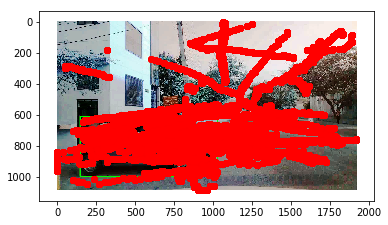

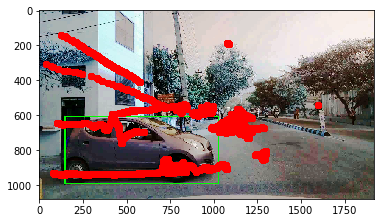

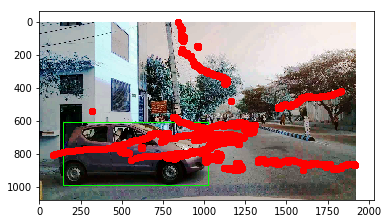

In [9]:
plot_gaze_points(train_gaze_point)
plot_gaze_points(val_gaze_point)
plot_gaze_points(test_gaze_point)

### I-DGAZE: Predicting driver gaze on road

In [10]:
model1 = Sequential()
model1.add(Conv2D(20, kernel_size=(3,3),strides=(1, 1),activation='relu',input_shape=(36,60,3)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
# model1.add(Conv2D(20, (3, 3), activation='relu'))
# model1.add(Dropout(0.5))
model1.add(Conv2D(50, (3,3), activation='relu',kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
# model.1add(Dropout(0.5))
model1.add(Flatten())
model1.add(Dense(500))
model1.add(Dense(2))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 34, 58, 20)        560       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 29, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 27, 50)        9050      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 13, 50)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4550)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               2275500   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1002      
Total para

In [11]:
train_face_features = np.concatenate((train_headpose_pupil[:,[1,2,3,4,5,6,7,9,10]],train_face_location[:]), axis =1)
val_face_features = np.concatenate((val_headpose_pupil[:,[1,2,3,4,5,6,7,9,10]],val_face_location[:]), axis =1)
test_face_features = np.concatenate((test_headpose_pupil[:,[1,2,3,4,5,6,7,9,10]],test_face_location[:]), axis =1)

opt = Adam(lr=0.00001)

model1.compile(loss='mae', optimizer=opt)
earlystopping = keras.callbacks.EarlyStopping(monitor = 'val_loss',min_delta = 1, patience =10, verbose =0, mode ='auto')

history = model1.fit([train_left_eye], train_gaze_point[:,:2], \
                      validation_data=([val_left_eye],val_gaze_point[:,:2]),\
                     epochs=300, batch_size=16, callbacks=[earlystopping], verbose=1, shuffle= True)
print(history.history.keys())

Train on 110987 samples, validate on 28439 samples
Epoch 1/300
110987/110987 [==============================] - 115s 1ms/step - loss: 203.3141 - val_loss: 170.0373
Epoch 2/300
110987/110987 [==============================] - 118s 1ms/step - loss: 181.7748 - val_loss: 163.5493
Epoch 3/300
110987/110987 [==============================] - 117s 1ms/step - loss: 176.9552 - val_loss: 160.5783
Epoch 4/300
110987/110987 [==============================] - 118s 1ms/step - loss: 173.9463 - val_loss: 157.6829
Epoch 5/300
110987/110987 [==============================] - 106s 957us/step - loss: 171.5907 - val_loss: 155.8682
Epoch 6/300
110987/110987 [==============================] - 116s 1ms/step - loss: 169.8054 - val_loss: 155.0800
Epoch 7/300
110987/110987 [==============================] - 119s 1ms/step - loss: 168.1558 - val_loss: 154.3277
Epoch 8/300
110987/110987 [==============================] - 115s 1ms/step - loss: 166.7311 - val_loss: 159.6768
Epoch 9/300
110987/110987 [================

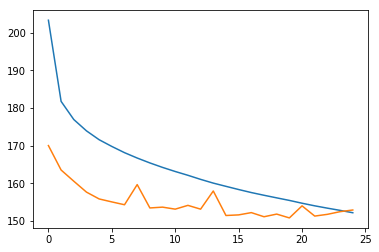

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [20]:
def gaze_error(left_eye,  gaze_point):
    scores = model1.evaluate(left_eye, gaze_point)
    return scores

In [21]:
train_error = gaze_error(train_left_eye , train_gaze_point[:,:2])
val_error = gaze_error(val_left_eye, val_gaze_point[:,:2])
test_error = gaze_error(test_left_eye, test_gaze_point[:,:2])
    
print("Train Error ==> ", train_error)
print("Val Error ==> ",  val_error)
print("Test Error ==> " ,test_error)

30012/30012 [==============================] - 2s 53us/step
Train Error ==>  153.27872198420502
Val Error ==>  152.93225750094362
Test Error ==>  159.5790843696701


## Plot output